In [2]:
import os
import sys
import time
import logging
import warnings
import numpy as np
import pandas as pd
import pprint as pp
import tensorflow as tf
import tensorflow_probability as tfp
import bokeh.plotting as bop
import bokeh.models as bom
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce   # https://contrib.scikit-learn.org/category_encoders/
import xgboost as xgb

from tqdm import tqdm
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_friedman1, make_friedman3
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import KFold
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from category_encoders.wrapper import NestedCVWrapper
from Simulation import make_sim, generate_data

sys.path.append("../")
from utils import (
    split, set_tf_loglevel,
    evaluate_model, evaluate_predictions, 
    plot_from_model, plot_from_predictions, plot_loss_curves, 
    embedding_preproc,
    plot_ridgeline
)
from glmmnet import build_glmmnet, predict_glmmnet, build_baseline_nn

In [5]:
df = pd.read_csv('train_data_30.csv')
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,category,y,y_true
0,0.185575,0.386599,0.831896,0.198697,0.916558,0.788311,0.722604,0.995695,0.845372,0.233727,45,0.528641,0.468409
1,0.322414,0.716656,0.102832,0.600091,0.136264,0.899254,0.246007,0.953597,0.788291,0.434094,11,0.574877,0.609680
2,0.254626,0.371629,0.569407,0.287561,0.859431,0.926623,0.037502,0.324082,0.337842,0.627109,55,0.432543,0.406111
3,0.075483,0.226522,0.920703,0.253677,0.876931,0.290830,0.236225,0.184916,0.137217,0.483095,40,0.142406,0.276231
4,0.730692,0.768266,0.309795,0.694997,0.949949,0.529765,0.419374,0.564843,0.771723,0.435250,40,0.535632,0.795249
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.645193,0.734041,0.859241,0.516427,0.417397,0.782510,0.359113,0.511229,0.609395,0.244058,6,1.096667,0.909033
4996,0.614561,0.410215,0.754180,0.684984,0.069953,0.056232,0.921783,0.884898,0.239098,0.665346,28,0.598210,0.904405
4997,0.430020,0.360744,0.935637,0.071311,0.714861,0.541421,0.662383,0.123916,0.312075,0.107557,42,0.372102,0.394303
4998,0.987075,0.517106,0.339425,0.512375,0.657278,0.335396,0.800623,0.589358,0.427358,0.567056,32,0.680524,0.736698


In [2]:
# Package parameters
# Display of sklearn pipelines
set_config(display="diagram")

# Seaborn plotting style
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)

# Suppress tensorflow messages
set_tf_loglevel(logging.FATAL)

# Output bokeh plots to notebook
output_notebook()

# Shorthand for tfp.distributions
tfd = tfp.distributions

Loading BokehJS ...

In [3]:
# Configure simulation parameters
exp_id = 1                         # experiment id
n_train = 5000                     # number of training observations
n_test = 2500                      # number of test observations
n = n_train + n_test               # total number of observations
n_categories = 100                 # number of categories for the categorical variable
f_structure = "friedman1"          # structure of the fixed effects f(X)
sig2noise = np.array([4, 1, 1])    # relative signal-to-noise of the fixed effects, random effects and irreducible error
y_dist = "gaussian"                # distribution of the response variable y
inverse_link = lambda x: x         # inverse of the identity link
cat_dist = "balanced"              # distribution of the categorical variable
random_seed = 42                   # random seed for reproducibility
log_plot = False                   # whether to plot the log transformed response and predictions
nn_loss = "mse"                    # loss function for the neural network

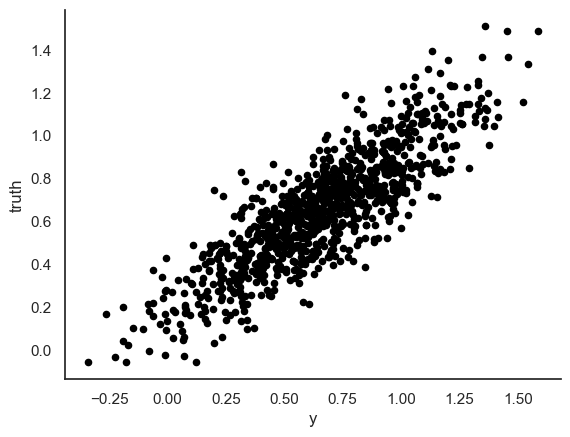

In [4]:

# Generate data
# Generate the fixed effects features X and f(X)
# Doc: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
if (f_structure == "friedman1"):
    # Out of the n_features features, only 5 are actually used to compute y.
    # The remaining features are independent of y.
    X, f_X = make_friedman1(n_samples=n, n_features=10, noise=0.0, random_state=random_seed)
elif (f_structure == "friedman3"):
    X, f_X = make_friedman3(n_samples=n, noise=0.0, random_state=random_seed)

# Simulate random effects and therefore the response variable y
X, y, truth, Zu = make_sim(X, f_X, n_categories, sig2noise, y_dist, inverse_link, cat_dist, random_seed)

# Plot y truth (i.e. the conditional mean) against y observed
# The smaller the noise component, the closer the points follow a straight line
_ = pd.DataFrame({"y": y[:1000], "truth": truth[:1000]}).plot.scatter(x="y", y="truth", color="black")

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = split(X, y, n_train)

# Conditional mean true values (unobservable in practice)
y_true_train = truth[:n_train]
y_true_test = truth[n_train:]

In [6]:
X_train.shape, X_test.shape

((5000, 11), (2500, 11))

In [7]:
# Combine X, y, and truth into a dataframe and save to files
train_data = pd.concat([
    X_train.reset_index(drop=True), 
    pd.DataFrame(y_train, columns=["y"]), 
    pd.DataFrame(y_true_train, columns=["y_true"])], axis=1)
test_data = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y_test, columns=["y"]),
    pd.DataFrame(y_true_test, columns=["y_true"])], axis=1)

In [8]:
hicard_var = "category"
x_num = [col for col in X.columns if col not in hicard_var]
X[x_num].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X1,7500.0,0.497615,0.288852,0.000125,0.248998,0.496073,0.749031,0.999805
X2,7500.0,0.494521,0.288870,0.000017,0.241848,0.494511,0.742734,0.999789
X3,7500.0,0.501841,0.287485,0.000012,0.251606,0.501669,0.749772,0.999957
X4,7500.0,0.499331,0.288483,0.000008,0.249689,0.500278,0.748632,0.999901
X5,7500.0,0.500825,0.288590,0.000135,0.252035,0.502506,0.753344,0.999841
X6,7500.0,0.506034,0.289164,0.000047,0.258761,0.505642,0.761703,0.999875
X7,7500.0,0.501282,0.285492,0.000006,0.254993,0.501586,0.744931,0.999972
X8,7500.0,0.496218,0.288666,0.000053,0.248826,0.494834,0.748937,0.999824
X9,7500.0,0.501712,0.287811,0.000110,0.251896,0.502645,0.750863,0.999925
X10,7500.0,0.498679,0.287630,0.000270,0.249869,0.498534,0.746239,0.999786


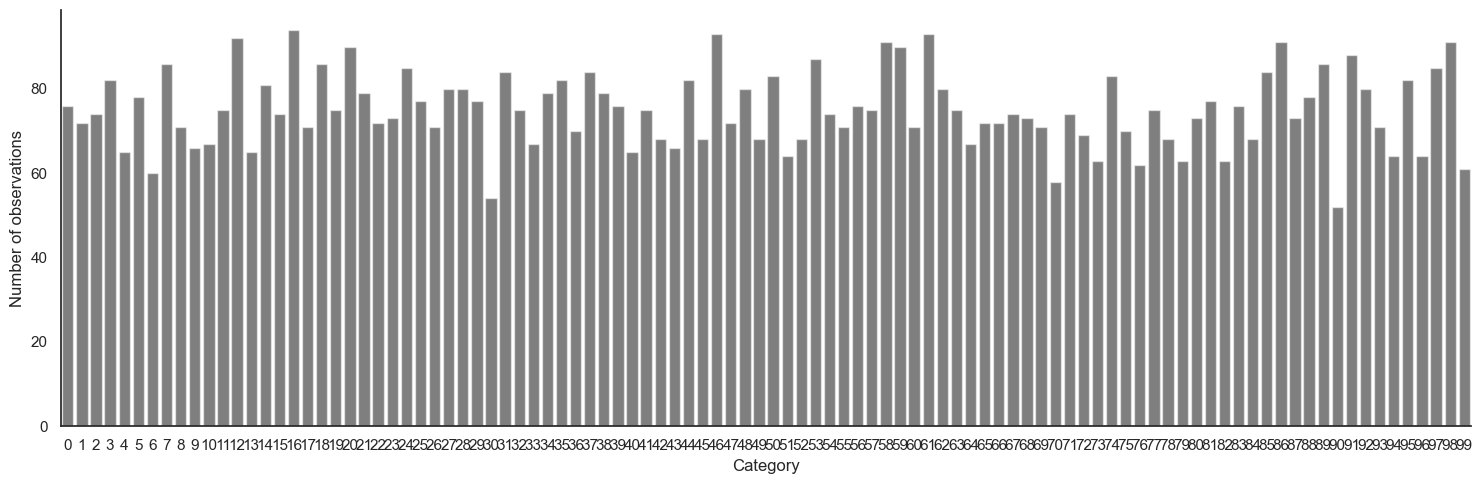

In [9]:
cat_count = X[hicard_var].value_counts()
fig = plt.figure(figsize=(15, 5))
_ = sns.barplot(x=cat_count.index, y=cat_count.values, color="black", alpha=0.5)
plt.ylabel("Number of observations")
plt.xlabel("Category")
plt.tight_layout()

GLM

In [10]:
ignore_cat_encoder = make_column_transformer(
    ("drop", [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_ignore_cat = make_pipeline(ignore_cat_encoder, LinearRegression())
# Apply the pipeline to the dataframe for prediction
GLM_ignore_cat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('linearregression', LinearRegression())])

In [11]:
train_scores = dict()
test_scores = dict()

print("> In-sample performance")
train_scores["GLM_ignore_cat"] = evaluate_model(GLM_ignore_cat, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_ignore_cat"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLM_ignore_cat"] = evaluate_model(GLM_ignore_cat, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GLM_ignore_cat"])

> In-sample performance
{'CRPS': 0.14310900069846103,
 'MAE': 0.20262877204739305,
 'MedAE': 0.1693606778776363,
 'MedPE': 0.241740066470962,
 'NLL': 0.048874104326739144,
 'R2': 0.3799743159135276,
 'RMSE': 0.25409058825391906,
 'RMSE_avg': 0.15385731178238027,
 'RMSE_avg_weighted': 0.15326304978025115}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.14272557899715393,
 'MAE': 0.2016853331178287,
 'MedAE': 0.16777610731704104,
 'MedPE': 0.24126061659871764,
 'NLL': 0.044849741054613194,
 'R2': 0.3931008214973465,
 'RMSE': 0.25307009022743493,
 'RMSE_avg': 0.16212135260176963,
 'RMSE_avg_weighted': 0.16319322865230176}


In [12]:
p = plot_from_model(GLM_ignore_cat, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)


In [13]:
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", drop="first"), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_one_hot = make_pipeline(one_hot_encoder, LinearRegression())
GLM_one_hot.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('linearregression', LinearRegression())])

In [14]:
print("> In-sample performance")
train_scores["GLM_one_hot"] = evaluate_model(GLM_one_hot, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_one_hot"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLM_one_hot"] = evaluate_model(GLM_one_hot, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GLM_one_hot"])

> In-sample performance
{'CRPS': 0.11416816856294194,
 'MAE': 0.16139807514282584,
 'MedAE': 0.1366230670779706,
 'MedPE': 0.1982641649358832,
 'NLL': -0.17770528927772133,
 'R2': 0.6059010121589711,
 'RMSE': 0.20257525689624756,
 'RMSE_avg': 9.937147129835773e-07,
 'RMSE_avg_weighted': 9.332011505989158e-07}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.1123245565498542,
 'MAE': 0.15872510471813694,
 'MedAE': 0.1331620572468138,
 'MedPE': 0.19016433316802056,
 'NLL': -0.19154578461882654,
 'R2': 0.6217438438442859,
 'RMSE': 0.19979082838036158,
 'RMSE_avg': 0.05072532701784069,
 'RMSE_avg_weighted': 0.04982970432760636}


In [15]:
p = plot_from_model(GLM_one_hot, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)


In [16]:
# Apply a cross-validated version of GLMM encoding

GLMM_encoder = make_column_transformer(
    # https://contrib.scikit-learn.org/category_encoders/wrapper.html
    (NestedCVWrapper(ce.glmm.GLMMEncoder(), cv=KFold(n_splits=5)), [hicard_var]),
    (MinMaxScaler(feature_range=(0, 1)), x_num), # not required for GLMs, applied here for consistency
)
GLM_GLMM_enc = make_pipeline(GLMM_encoder, LinearRegression())
GLM_GLMM_enc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nestedcvwrapper',
                                                  NestedCVWrapper(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                                  feature_encoder=GLMMEncoder()),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('linearregression', LinearRegression())])

In [17]:
# Check how the GLMMencoder works
# Docs: https://contrib.scikit-learn.org/category_encoders/_modules/category_encoders/wrapper.html#NestedCVWrapper.transform
# https://contrib.scikit-learn.org/category_encoders/_modules/category_encoders/glmm.html#GLMMEncoder
GLMM_encodings = pd.DataFrame({
    "category": X_train[hicard_var].values,
    "encoding": NestedCVWrapper(ce.GLMMEncoder(), cv=KFold(n_splits=5)).fit_transform(X_train["category"], y_train).values.ravel(),
})
GLMM_encodings

,category,encoding
0,51,0.340667
1,92,-0.002120
2,14,0.234305
3,71,-0.032545
4,60,-0.132732
...,...,...
4995,48,-0.150653
4996,57,0.058180
4997,38,-0.122347
4998,79,-0.027919


In [18]:
# Different values for different folds (on the training set)
GLMM_encodings[GLMM_encodings["category"] == 51].value_counts()

category  encoding
51        0.265839    12
          0.340667    12
          0.316554     7
          0.273471     6
          0.280705     5
dtype: int64

In [19]:
# Plot GLMM encodings vs true random effects
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Encodings", width=400, height=400)
p.add_layout(bom.Title(text="Model: GLMM encodings", text_font_style="italic"), "above")
GLMM_encodings = GLMM_encoder.named_transformers_["nestedcvwrapper"].transform(X_train[hicard_var])
p.circle(Zu[:n_train], GLMM_encodings.values.ravel(), color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

In [20]:
print("> In-sample performance")
train_scores["GLM_GLMM_enc"] = evaluate_model(GLM_GLMM_enc, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GLM_GLMM_enc"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GLM_GLMM_enc"] = evaluate_model(GLM_GLMM_enc, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GLM_GLMM_enc"])

> In-sample performance
{'CRPS': 0.11534203442830271,
 'MAE': 0.16335589205154746,
 'MedAE': 0.1375646369452398,
 'MedPE': 0.20151583782581656,
 'NLL': -0.16709453476883926,
 'R2': 0.5974482641242197,
 'RMSE': 0.2047361774409953,
 'RMSE_avg': 0.030397940842192155,
 'RMSE_avg_weighted': 0.029620259351072452}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.11397651502660883,
 'MAE': 0.161099899041167,
 'MedAE': 0.13783489081702688,
 'MedPE': 0.19518101079580627,
 'NLL': -0.17821915173518868,
 'R2': 0.6115265243757838,
 'RMSE': 0.20247118781780293,
 'RMSE_avg': 0.06045183469225831,
 'RMSE_avg_weighted': 0.05976245049744214}


In [21]:
p = plot_from_model(GLM_GLMM_enc, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)


Gradient Boosting Machine (GBM)

In [22]:
GBM = xgb.XGBRegressor(n_jobs=-1, learning_rate=0.1, max_depth=2, random_state=random_seed)
GBM_ignore_cat = make_pipeline(ignore_cat_encoder, GBM)
GBM_ignore_cat.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stoppi...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

1) GBM Ignore Cat

In [23]:
print("> In-sample performance")
train_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_ignore_cat"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_ignore_cat"] = evaluate_model(GBM_ignore_cat, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_ignore_cat"])

> In-sample performance
{'CRPS': 0.12871378252677268,
 'MAE': 0.18150761584438227,
 'MedAE': 0.1512560700135368,
 'MedPE': 0.21428897493322613,
 'NLL': -0.05618164161068075,
 'R2': 0.49747297918575695,
 'RMSE': 0.22875123525588648,
 'RMSE_avg': 0.14860485736095225,
 'RMSE_avg_weighted': 0.14816956573700488}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.1327380362299808,
 'MAE': 0.18808066094192694,
 'MedAE': 0.15906669097425047,
 'MedPE': 0.22535555673786473,
 'NLL': -0.02947601750245098,
 'R2': 0.47693216351247214,
 'RMSE': 0.23494248236079068,
 'RMSE_avg': 0.16028178477943414,
 'RMSE_avg_weighted': 0.16104858076977363}


In [24]:
p = plot_from_model(GBM_ignore_cat, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)


2.GBM ONE HOT ENCODING

In [25]:
GBM_one_hot = make_pipeline(one_hot_encoder, GBM)
GBM_one_hot.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_byno...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [26]:
print("> In-sample performance")
train_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_one_hot"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_one_hot"] = evaluate_model(GBM_one_hot, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_one_hot"])

> In-sample performance
{'CRPS': 0.12103828468070214,
 'MAE': 0.1714942738707283,
 'MedAE': 0.14327314543405273,
 'MedPE': 0.2020993846210404,
 'NLL': -0.12122498525433925,
 'R2': 0.558771569662499,
 'RMSE': 0.21434604902556678,
 'RMSE_avg': 0.11553419225682125,
 'RMSE_avg_weighted': 0.1140720596734828}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.12490240605217733,
 'MAE': 0.17806725180664376,
 'MedAE': 0.15361453597189456,
 'MedPE': 0.21676461442872455,
 'NLL': -0.09407729102900751,
 'R2': 0.5403301037257904,
 'RMSE': 0.2202447558949915,
 'RMSE_avg': 0.12861274568008238,
 'RMSE_avg_weighted': 0.12956488971051283}


In [27]:
p = plot_from_model(GBM_one_hot, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)


3. GBM GLMM_ENCODING

In [28]:
# Apply a cross-validated version of GLMM encoding
GBM_GLMM_enc = make_pipeline(GLMM_encoder, GBM)
GBM_GLMM_enc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('nestedcvwrapper',
                                                  NestedCVWrapper(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                                                  feature_encoder=GLMMEncoder()),
                                                  ['category']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10'])])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, ca...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [29]:
print("> In-sample performance")
train_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_train, y_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["GBM_GLMM_enc"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["GBM_GLMM_enc"] = evaluate_model(GBM_GLMM_enc, X_test, y_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["GBM_GLMM_enc"])

> In-sample performance
{'CRPS': 0.10021689856049819,
 'MAE': 0.1420443787535444,
 'MedAE': 0.11903401316090644,
 'MedPE': 0.17195902769660515,
 'NLL': -0.3072883161597434,
 'R2': 0.695875832981913,
 'RMSE': 0.17795459431217428,
 'RMSE_avg': 0.035709403937319376,
 'RMSE_avg_weighted': 0.03546623380638774}
--------------------------------------------------------------------------------
> Out-of-sample performance
{'CRPS': 0.10266099078272334,
 'MAE': 0.1456969485447318,
 'MedAE': 0.1232422255114225,
 'MedPE': 0.1757671314512327,
 'NLL': -0.28426962942632,
 'R2': 0.6857703970500991,
 'RMSE': 0.18209838471052583,
 'RMSE_avg': 0.059451736728828176,
 'RMSE_avg_weighted': 0.06002051962286526}


In [30]:
p = plot_from_model(GBM_GLMM_enc, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)


3.ENTITY EMBEDINGS WITH NEURAL NETWORK

In [31]:
# Preprocess the data
ct_nn = make_column_transformer(
    (ce.ordinal.OrdinalEncoder(handle_unknown="value"), [hicard_var]), # "value" encodes unknown categories as "-1"
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
X_train_ct = ct_nn.fit_transform(X_train)
X_test_ct = ct_nn.transform(X_test)

# Convert to dataframes
colnames = [hicard_var] + x_num
X_train_ct = pd.DataFrame(X_train_ct, columns=colnames)
X_test_ct = pd.DataFrame(X_test_ct, columns=colnames)
# Convert dataframe to lists to feed into Keras model
X_embed_train, X_embed_test = embedding_preproc(X_train_ct, X_test_ct, [hicard_var])

In [35]:
import pydot
from tensorflow.keras.utils import plot_model
NN_ee = build_baseline_nn(X_train_ct, print_embeddings=True, random_state=random_seed, cat_vars=[hicard_var], num_vars=x_num)
plot_model(NN_ee, dpi=600, show_layer_activations=True, rankdir="LR")

[category] cardinality: 100 and embedding dim: 3
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
import pydot
import graphviz

print("pydot version:", pydot.__version__)
print("graphviz version:", graphviz.__version__)

pydot version: 1.4.2
graphviz version: 0.20.1


In [38]:
NN_ee.count_params()


3821

In [57]:
# Define training parameters
epochs = 500
patience = 50
batch_size = 256
es = EarlyStopping(patience=patience, restore_best_weights=True, monitor="val_loss", verbose=2)

NN_ee = build_baseline_nn(X_train_ct, random_state=random_seed, num_vars=x_num, cat_vars=[hicard_var])
hist = NN_ee.fit(
    (tuple(X_embed_train), X_train_ct[x_num]), y_train, validation_split=0.2, 
    epochs=epochs, callbacks=[es], batch_size=batch_size, verbose=0)
hist = hist.history

y_pred_train = NN_ee.predict((tuple(X_embed_train), X_train_ct[x_num])).flatten()
y_pred_test = NN_ee.predict((tuple(X_embed_test), X_test_ct[x_num])).flatten()

ValueError: Columns must be same length as key

In [4]:
print("> In-sample performance")
train_scores["NN_ee"] = evaluate_predictions(y_train, y_pred_train, categories=X_train[hicard_var], likelihood=y_dist)
pp.pprint(train_scores["NN_ee"])

print("-" * 80)
print("> Out-of-sample performance")
test_scores["NN_ee"] = evaluate_predictions(y_test, y_pred_test, categories=X_test[hicard_var], likelihood=y_dist)
pp.pprint(test_scores["NN_ee"])

> In-sample performance


NameError: name 'evaluate_predictions' is not defined

In [5]:
p = plot_from_predictions(
    y_pred_train=y_pred_train,
    y_train=y_true_train,
    y_pred_test=y_pred_test,
    y_test=y_true_test,
    log_scale=log_plot,
)

NameError: name 'plot_from_predictions' is not defined

In [7]:
# Extract embeddings from the fitted neural network model
embeddings = NN_ee.get_layer(f"{hicard_var}_embed").get_weights()[0]
embeddings = pd.DataFrame(embeddings, columns=["embedding_" + str(i) for i in range(embeddings.shape[1])])
oe = ct_nn.named_transformers_["ordinalencoder"]
categories = np.array(oe.category_mapping[0]["mapping"])[:-1]
embeddings = pd.concat([pd.DataFrame(categories, columns=[hicard_var]), embeddings], axis=1)
embeddings

NameError: name 'NN_ee' is not defined